# Portfolios'Performance Evaluation
**Prepared by:** Adisorn Promkaewngarm

# Import Library

In [1]:
!pip install -q arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 45.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from arch.bootstrap import CircularBlockBootstrap

## Functions

In [3]:
def calculate_performance_metrics(returns_df, risk_free_rate=0.01, ann_factor=52):
    """
    Calculates key performance metrics from a DataFrame or Series of WEEKLY returns.
    Includes Total Return and Max Drawdown as percentages.
    """
    def compute_single_series(portfolio_returns):
        # 1. Total Return (%)
        # This shows the absolute cumulative growth of the investment
        total_return = (1 + portfolio_returns).prod() - 1
        total_return_pct = total_return * 100

        # 2. Annualized Return (%)
        num_weeks = len(portfolio_returns)
        annualized_return = (1 + total_return) ** (ann_factor / num_weeks) - 1
        annualized_return_pct = annualized_return * 100

        # 3. Annualized Risk (Volatility %)
        annualized_risk = portfolio_returns.std() * np.sqrt(ann_factor)
        annualized_risk_pct = annualized_risk * 100

        # 4. Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_risk

        # 5. Sortino Ratio
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_deviation = downside_returns.std() * np.sqrt(ann_factor)

        if downside_deviation == 0 or np.isnan(downside_deviation):
            sortino_ratio = np.nan
        else:
            sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation

        # 6. Weekly Risk Metrics (%)
        weekly_var_95 = np.percentile(portfolio_returns, 5) * 100
        weekly_cvar_95 = portfolio_returns[portfolio_returns <= (weekly_var_95/100)].mean() * 100

        # 7. Maximum Drawdown (%)
        cumulative_wealth = (1 + portfolio_returns).cumprod()
        running_max = cumulative_wealth.cummax()
        drawdown = (cumulative_wealth - running_max) / running_max
        max_drawdown_pct = drawdown.min() * 100

        return {
            'Total Return (%)': total_return_pct,
            'Annualized Return (%)': annualized_return_pct,
            'Annualized Volatility (%)': annualized_risk_pct,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Weekly VaR 95% (%)': weekly_var_95,
            'Weekly CVaR 95% (%)': weekly_cvar_95,
            'Max Drawdown (%)': max_drawdown_pct
        }

    if isinstance(returns_df, pd.DataFrame):
        return returns_df.apply(lambda x: pd.Series(compute_single_series(x)))
    else:
        return pd.Series(compute_single_series(returns_df))

# Data Prepareation

## Import Data

In [4]:
# --- 1. Import Data ---
path_all_ret = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/raw/main/df_all_assets_log_ret_weekly.csv'
path_port_ret = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/raw/main/portfolio_returns_final.csv'

# Load Asset Log Returns
df_assets_log = pd.read_csv(path_all_ret, index_col=0, parse_dates=True)

# Load Final Portfolio Returns (The 7 strategies we merged)
df_port_returns = pd.read_csv(path_port_ret, index_col=0, parse_dates=True)

# --- 2. Convert Asset Log Returns to Simple Returns ---
# Portfolio returns were calculated as simple returns (w * R),
# so we convert assets to simple returns for consistent "Growth" math.
df_assets_simple = np.exp(df_assets_log) - 1

# --- 3. Filter for Unified Research Period (2013 - 2026) ---
df_assets_simple = df_assets_simple.loc['2013':]
df_port_returns = df_port_returns.loc['2013':]

print(f"Data Loaded Successfully.")
print(f"Asset Universe: {df_assets_simple.shape[1]} columns | Timeline: {df_assets_simple.index.min().date()} to {df_assets_simple.index.max().date()}")
print(f"Portfolio Strategies: {df_port_returns.shape[1]} columns | Timeline: {df_port_returns.index.min().date()} to {df_port_returns.index.max().date()}")

Data Loaded Successfully.
Asset Universe: 114 columns | Timeline: 2013-01-07 to 2025-12-29
Portfolio Strategies: 7 columns | Timeline: 2013-01-07 to 2025-12-29


## Train-Test Split

In [5]:
# 1. Split Strategy Returns ---
df_port_train = df_port_returns.loc['2013':'2022']
df_port_test = df_port_returns.loc['2023':'2025']

# 2. Split Asset Returns (for Benchmarking/Contribution analysis)
df_assets_train = df_assets_simple.loc['2013':'2022']
df_assets_test = df_assets_simple.loc['2023':'2025']

In [6]:
# --- Simple Index & Continuity Check ---

# 1. Verification of Portfolios
print("--- Portfolio Index Verification ---")
print(f"Train Period: {df_port_train.index.min().date()} to {df_port_train.index.max().date()} | Count: {len(df_port_train)} weeks")
print(f"Test Period:  {df_port_test.index.min().date()} to {df_port_test.index.max().date()} | Count: {len(df_port_test)} weeks")

# 2. Verification of Assets
print("\n--- Asset Index Verification ---")
print(f"Train Period: {df_assets_train.index.min().date()} to {df_assets_train.index.max().date()} | Count: {len(df_assets_train)} weeks")
print(f"Test Period:  {df_assets_test.index.min().date()} to {df_assets_test.index.max().date()} | Count: {len(df_assets_test)} weeks")

# 3. Continuity & Alignment Checks
continuity_gap = df_port_test.index.min() - df_port_train.index.max()
alignment_train = df_port_train.index.equals(df_assets_train.index)
alignment_test = df_port_test.index.equals(df_assets_test.index)

print("\n--- Integrity Summary ---")
print(f"Gap between Train and Test: {continuity_gap.days} days")
print(f"Train Alignment (Port vs Assets): {'Match' if alignment_train else 'Mismatch'}")
print(f"Test Alignment (Port vs Assets):  {'Match' if alignment_test else 'Mismatch'}")

--- Portfolio Index Verification ---
Train Period: 2013-01-07 to 2022-12-26 | Count: 521 weeks
Test Period:  2023-01-02 to 2025-12-29 | Count: 157 weeks

--- Asset Index Verification ---
Train Period: 2013-01-07 to 2022-12-26 | Count: 521 weeks
Test Period:  2023-01-02 to 2025-12-29 | Count: 157 weeks

--- Integrity Summary ---
Gap between Train and Test: 7 days
Train Alignment (Port vs Assets): Match
Test Alignment (Port vs Assets):  Match


## Compute net returns

In [7]:
# 1. Define the Fee Factor (The remaining capital after paying the fee)
# If fee is 0.1605%, we keep 99.8395% of our money
fee = 0.0015 * 1.07
fee_factor = 1 - fee

# 2. Create Net Return DataFrames
df_port_train_net = df_port_train.copy()
df_port_test_net = df_port_test.copy()

# 3. Adjust Active Strategies (Multiplicative adjustment)
# Net Return = ((1 + Gross Return) * (1 - Fee)) - 1
df_port_train_net.iloc[:, 1:] = (1 + df_port_train.iloc[:, 1:]) * fee_factor - 1
df_port_test_net.iloc[:, 1:] = (1 + df_port_test.iloc[:, 1:]) * fee_factor - 1

# 4. Adjust Buy-and-Hold Strategy (Entry and Exit only)
# Training Segment
# Entry (First week)
df_port_train_net.iloc[0, 0] = (1 + df_port_train.iloc[0, 0]) * fee_factor - 1
# Exit (Last week)
df_port_train_net.iloc[-1, 0] = (1 + df_port_train.iloc[-1, 0]) * fee_factor - 1

# Testing Segment
# Entry (First week)
df_port_test_net.iloc[0, 0] = (1 + df_port_test.iloc[0, 0]) * fee_factor - 1
# Exit (Last week)
df_port_test_net.iloc[-1, 0] = (1 + df_port_test.iloc[-1, 0]) * fee_factor - 1

# Compute Performance Metrics

## Before Transaction Costs

In [8]:
# --- 1. Training Period Metrics (Gross) ---
train_metrics_gross = calculate_performance_metrics(df_port_train, risk_free_rate=0.01)

# --- 2. Testing Period Metrics (Gross) ---
test_metrics_gross = calculate_performance_metrics(df_port_test, risk_free_rate=0.01)

In [9]:
print("--- [TRAIN] Gross Performance (2013-2022) ---")
display(train_metrics_gross.round(4))

--- [TRAIN] Gross Performance (2013-2022) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),3.3038,137.3851,276.7965,4276.5430,4149.8487,4388.6537,4275.4103
Annualized Return (%),0.3249,9.0117,14.1564,45.8136,45.3867,46.1822,45.8099
Annualized Volatility (%),13.8174,15.4923,18.3391,15.6614,15.7255,15.6717,15.7414
Sharpe Ratio,-0.0489,0.5171,0.7174,2.8614,2.8226,2.8831,2.8466
Sortino Ratio,-0.0647,0.6558,0.9382,5.2597,5.1772,5.3019,5.2287
Weekly VaR 95% (%),-2.8216,-3.0567,-3.8502,-2.1734,-2.1887,-2.1734,-2.1887
Weekly CVaR 95% (%),-4.5732,-5.0118,-5.9912,-3.4458,-3.4878,-3.4458,-3.4878
Max Drawdown (%),-36.0501,-34.4109,-26.4764,-17.0447,-16.9828,-17.0447,-16.9828


In [10]:
print("\n--- [TEST] Gross Performance (2023-2025) ---")
display(test_metrics_gross.round(4))


--- [TEST] Gross Performance (2023-2025) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),-25.9962,-25.0838,-19.9045,4.2158,4.1214,1.1137,1.1006
Annualized Return (%),-9.4902,-9.1221,-7.0875,1.3771,1.3466,0.3675,0.3632
Annualized Volatility (%),12.7160,13.7164,11.9633,11.0691,11.1141,10.8570,10.9282
Sharpe Ratio,-0.8250,-0.7380,-0.6760,0.0341,0.0312,-0.0583,-0.0583
Sortino Ratio,-1.4078,-1.2400,-0.8455,0.0422,0.0389,-0.0697,-0.0704
Weekly VaR 95% (%),-2.9252,-2.8514,-2.7479,-2.6199,-2.6199,-2.6194,-2.6631
Weekly CVaR 95% (%),-3.5705,-3.8767,-4.3486,-3.8344,-3.8330,-3.8344,-3.8369
Max Drawdown (%),-32.1911,-34.0737,-22.4876,-18.6711,-18.8746,-18.1968,-18.3929


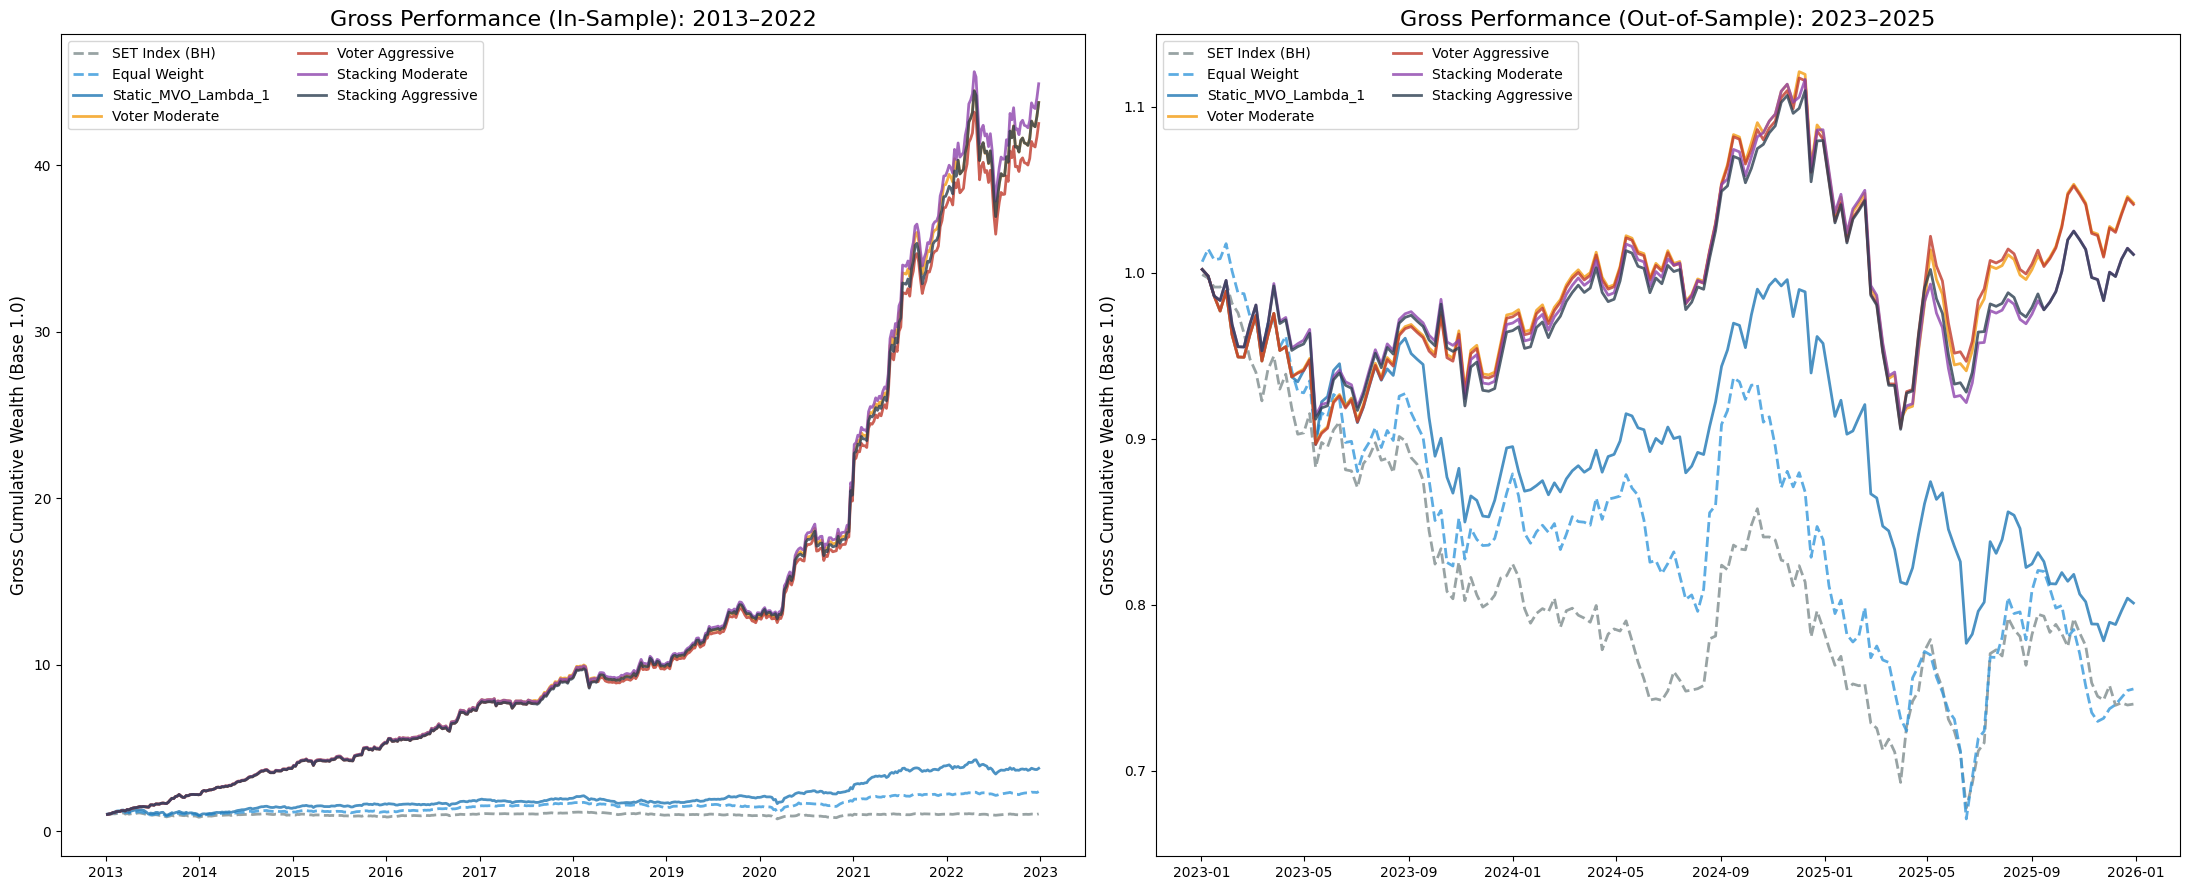

In [11]:
# 1. Calculate Cumulative Gross Growth
df_cum_train_gross = (1 + df_port_train).cumprod()
df_cum_test_gross = (1 + df_port_test).cumprod()


# Visual Configuration (Redefined for this block) ---
display_names = {
    'SET_Index_BH': 'SET Index (BH)',
    'Equal_Weight': 'Equal Weight',
    'Static_MVO_Lambda_2': 'Static MVO ($\\lambda=2$)',
    'Voter_Moderate': 'Voter Moderate',
    'Voter_Aggressive': 'Voter Aggressive',
    'Stacking_Moderate': 'Stacking Moderate',
    'Stacking_Aggressive': 'Stacking Aggressive'
}

colors = {
    'SET_Index_BH': '#7f8c8d',
    'Equal_Weight': '#3498db',
    'Static_MVO_Lambda_2': '#27ae60',
    'Voter_Moderate': '#f39c12',
    'Voter_Aggressive': '#c0392b',
    'Stacking_Moderate': '#8e44ad',
    'Stacking_Aggressive': '#2c3e50'
}

# 2. Create Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# --- Plot A: Training Period (Gross) ---
for col in df_cum_train_gross.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2'] else '-'
    ax1.plot(df_cum_train_gross[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=0.8, linewidth=2.0)

ax1.set_title('Gross Performance (In-Sample): 2013–2022', fontsize=16)
ax1.set_ylabel('Gross Cumulative Wealth (Base 1.0)', fontsize=12)
ax1.grid(False)
ax1.legend(loc='upper left', fontsize=10, ncol=2)

# --- Plot B: Testing Period (Gross) ---
for col in df_cum_test_gross.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2'] else '-'
    ax2.plot(df_cum_test_gross[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=0.8, linewidth=2.0)

ax2.set_title('Gross Performance (Out-of-Sample): 2023–2025', fontsize=16)
ax2.set_ylabel('Gross Cumulative Wealth (Base 1.0)', fontsize=12)
ax2.grid(False)
ax2.legend(loc='upper left', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

## Net Returns

In [12]:
# --- 1. Training Period Metrics (Net of Costs) ---
# risk_free_rate = 0.01 (1%) as an annualized baseline
train_metrics_table = calculate_performance_metrics(df_port_train_net, risk_free_rate=0.01)

print("--- [TRAIN PERIOD] Performance Metrics (2013-2022) ---")
train_metrics_table.round(4)

--- [TRAIN PERIOD] Performance Metrics (2013-2022) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),2.9724,2.8022,63.1758,1795.3099,1740.4436,1843.8607,1794.8194
Annualized Return (%),0.2928,0.2762,5.0086,34.1290,33.7363,34.4681,34.1256
Annualized Volatility (%),13.8150,15.4674,18.3096,15.6363,15.7002,15.6465,15.7162
Sharpe Ratio,-0.0512,-0.0468,0.2189,2.1187,2.0851,2.1390,2.1077
Sortino Ratio,-0.0677,-0.0595,0.2869,3.9970,3.9076,4.0374,3.9552
Weekly VaR 95% (%),-2.8216,-3.2123,-4.0045,-2.3304,-2.3456,-2.3304,-2.3456
Weekly CVaR 95% (%),-4.5732,-5.1642,-6.1421,-3.6008,-3.6427,-3.6008,-3.6427
Max Drawdown (%),-36.0501,-47.1643,-34.6504,-18.6283,-18.5677,-18.6283,-18.5677


In [13]:
# --- 2. Testing Period Metrics (Net of Costs) ---
# Using the same risk_free_rate for consistent benchmarking
test_metrics_table = calculate_performance_metrics(df_port_test_net, risk_free_rate=0.01)

print("--- [TEST PERIOD] Performance Metrics (2023-2025) ---")
test_metrics_table.round(4)

--- [TEST PERIOD] Performance Metrics (2023-2025) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),-26.2335,-41.7827,-37.7579,-19.0140,-19.0874,-21.4246,-21.4348
Annualized Return (%),-9.5864,-16.4045,-14.5330,-6.7467,-6.7746,-7.6753,-7.6793
Annualized Volatility (%),12.7153,13.6944,11.9441,11.0513,11.0963,10.8396,10.9106
Sharpe Ratio,-0.8326,-1.2709,-1.3005,-0.7010,-0.7007,-0.8003,-0.7955
Sortino Ratio,-1.4200,-2.0478,-1.6173,-0.8622,-0.8681,-0.9540,-0.9563
Weekly VaR 95% (%),-2.9252,-3.0073,-2.9040,-2.7762,-2.7762,-2.7757,-2.8193
Weekly CVaR 95% (%),-3.5705,-4.0309,-4.5022,-3.9887,-3.9874,-3.9887,-3.9912
Max Drawdown (%),-32.1911,-46.0711,-39.0630,-24.5866,-25.0301,-25.1045,-25.1007


<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2341541336.py:11: SyntaxWarning: invalid escape sequence '\l'
  'Static_MVO_Lambda_2': 'Static MVO ($\lambda=2$)',


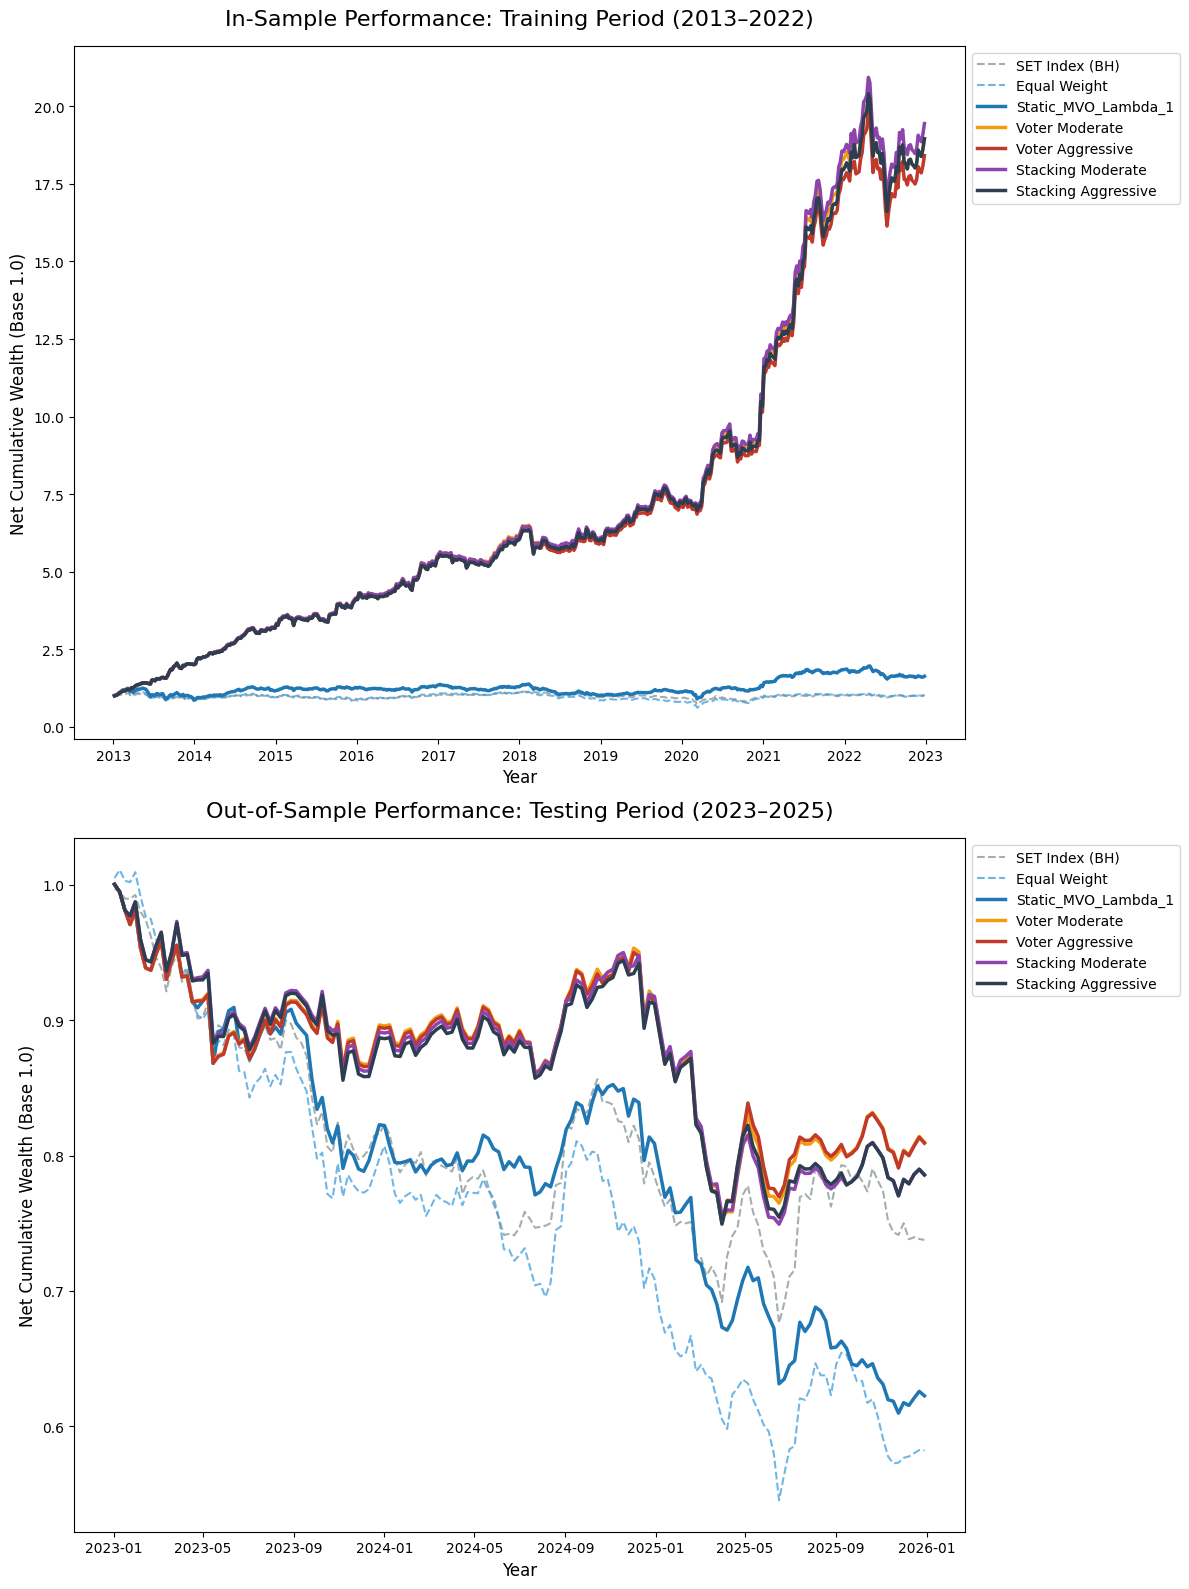

In [14]:
import matplotlib.pyplot as plt

# 1. Calculate Cumulative Growth for both periods (Base 1.0)
df_cum_train = (1 + df_port_train_net).cumprod()
df_cum_test = (1 + df_port_test_net).cumprod()

# 2. Configuration for Visual Consistency
display_names = {
    'SET_Index_BH': 'SET Index (BH)',
    'Equal_Weight': 'Equal Weight',
    'Static_MVO_Lambda_2': 'Static MVO ($\lambda=2$)',
    'Voter_Moderate': 'Voter Moderate',
    'Voter_Aggressive': 'Voter Aggressive',
    'Stacking_Moderate': 'Stacking Moderate',
    'Stacking_Aggressive': 'Stacking Aggressive'
}

colors = {
    'SET_Index_BH': '#7f8c8d', 'Equal_Weight': '#3498db', 'Static_MVO_Lambda_2': '#27ae60',
    'Voter_Moderate': '#f39c12', 'Voter_Aggressive': '#c0392b',
    'Stacking_Moderate': '#8e44ad', 'Stacking_Aggressive': '#2c3e50'
}

# 3. Create Subplots (2 rows, 1 column)
# Adjusted figsize for vertical stack: 12 inches wide, 16 inches tall
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# --- Plot A: Training Period (2013-2022) ---
for col in df_cum_train.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO'] else '-'
    alpha = 0.7 if ls == '--' else 1.0
    lw = 1.5 if ls == '--' else 2.5

    ax1.plot(df_cum_train[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=alpha, linewidth=lw)

ax1.set_title('In-Sample Performance: Training Period (2013–2022)', fontsize=16, pad=15)
ax1.set_ylabel('Net Cumulative Wealth (Base 1.0)', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.grid(False)
# Move legend outside to the right
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# --- Plot B: Testing Period (2023-2025) ---
for col in df_cum_test.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO'] else '-'
    alpha = 0.7 if ls == '--' else 1.0
    lw = 1.5 if ls == '--' else 2.5

    ax2.plot(df_cum_test[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=alpha, linewidth=lw)

ax2.set_title('Out-of-Sample Performance: Testing Period (2023–2025)', fontsize=16, pad=15)
ax2.set_ylabel('Net Cumulative Wealth (Base 1.0)', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.grid(False)
# Move legend outside to the right
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# 4. Final Formatting and Saving
plt.tight_layout()

# Save as high-resolution JPG (300 DPI)
# bbox_inches='tight' ensures the legend outside the plot is included in the file
plt.savefig('portfolio_performance_CumRet.jpg', dpi=300, format='jpg', bbox_inches='tight')

plt.show()

# Hypothesis Testing

In [15]:
import numpy as np
import pandas as pd
from scipy import stats
from arch.bootstrap import CircularBlockBootstrap

# Set global seed for standard numpy operations
np.random.seed(42)

In [16]:
def get_mean_se_hac(data, lag=5):
    """
    Calculates the Heteroskedasticity and Autocorrelation Consistent (HAC) Standard Error
    for the mean of a return series using the Newey-West estimator.
    """
    T = len(data)
    mu = np.mean(data)
    demeaned = data - mu # Center the data around the mean

    # --- Step 1: Calculate the sample variance (Lag 0) ---
    # This is equivalent to the standard OLS variance
    lr_var = np.sum(demeaned**2) / T

    # --- Step 2: Add weighted autocovariances for specified lags ---
    # Newey-West uses a 'Bartlett Kernel' (weight) to ensure the variance is always positive.
    for j in range(1, lag + 1):
        # Calculate autocovariance at lag j
        gamma_j = np.sum(demeaned[j:] * demeaned[:-j]) / T

        # Calculate Bartlett weight: decays as the lag increases
        weight = 1 - (j / (lag + 1))

        # Add the two-sided covariance contribution (j and -j)
        lr_var += 2 * weight * gamma_j

    # Standard error is the square root of the Long-Run Variance divided by Sample Size
    return np.sqrt(lr_var / T)

def get_sharpe_diff_se_hac(r_s, r_b, rf, lag=5):
    """
    Calculates the Robust Standard Error for the DIFFERENCE between two Sharpe Ratios.
    """
    T = len(r_s)

    # Calculate first and second moments for both Strategy (s) and Benchmark (b)
    mu_s, mu_b = np.mean(r_s), np.mean(r_b)
    gam_s, gam_b = np.mean(r_s**2), np.mean(r_b**2)

    # --- Step 1: Define the Gradient (Partial Derivatives) ---
    # This function calculates how the Sharpe Ratio changes if mu or gamma shifts slightly.
    def grad_sharpe(mu, gam, rf_adj):
        sigma = np.sqrt(gam - mu**2) # Calculate Standard Deviation from moments

        # Derivative with respect to Mean (mu)
        d_mu = (gam - mu*rf_adj + mu*(mu-rf_adj)) / (sigma**3)
        # Derivative with respect to Second Moment (gamma)
        d_gam = -0.5 * (mu - rf_adj) / (sigma**3)

        return d_mu, d_gam

    # Get gradients for both series
    ds_dmu, ds_dgam = grad_sharpe(mu_s, gam_s, rf)
    db_dmu, db_dgam = grad_sharpe(mu_b, gam_b, rf)

    # Vector D: The Jacobian matrix for the difference (Strategy - Benchmark)
    D = np.array([ds_dmu, -db_dmu, ds_dgam, -db_dgam])

    # --- Step 2: Construct the Moment Matrix (Y) ---
    # Y contains the 'innovations' for the means and variances of both series
    Y = np.vstack([r_s-mu_s, r_b-mu_b, r_s**2-gam_s, r_b**2-gam_b]).T

    # --- Step 3: Calculate the HAC Covariance Matrix (Psi_hat) ---
    # This matrix captures the correlations between the returns and volatilities
    # across time and across the two strategies.
    Psi_hat = (Y.T @ Y) / T # Initial covariance

    for j in range(1, lag + 1):
        # Calculate cross-autocovariance matrix at lag j
        Gamma_j = (Y[j:].T @ Y[:-j]) / T
        weight = 1 - (j / (lag + 1)) # Bartlett Kernel

        # Symmetric update for the covariance matrix
        Psi_hat += weight * (Gamma_j + Gamma_j.T)

    # --- Step 4: Apply the Delta Method Formula ---
    # SE = sqrt( D' * Psi * D / T )
    # This projects the variance of the raw returns into the 'Sharpe Space'
    return np.sqrt((D.T @ Psi_hat @ D) / T)

In [17]:
def studentized_bootstrap_pvalue(series_pair, stat_func, se_func, block_size=10, n_boot=5000, **kwargs):
    """
    Performs a Studentized Circular Block Bootstrap to determine the statistical significance
    of the performance difference between a strategy and a benchmark.
    'Studentized' means it compares T-statistics rather than just raw differences.
    """
    values = series_pair.values

    # --- Step 1: Calculate the 'Real World' Observed Statistics ---
    obs_stat = stat_func(values[:, 0], values[:, 1], **kwargs)
    obs_se = se_func(values[:, 0], values[:, 1], **kwargs)
    t_orig = np.abs(obs_stat) / obs_se if obs_se != 0 else 0

    # --- Step 2: Initialize the Circular Block Bootstrap ---
    # We remove 'random_state' from here to avoid the TypeError
    bs = CircularBlockBootstrap(block_size, values)
    boot_t_stats = []

    # --- Step 3: The Resampling Loop ---
    # We set the seed globally right before the loop starts to ensure
    # the bootstrap generator picks the same blocks every time you run this.
    np.random.seed(42)

    for data in bs.bootstrap(n_boot):
        resampled_array = data[0][0]

        stat_star = stat_func(resampled_array[:, 0], resampled_array[:, 1], **kwargs)
        se_star = se_func(resampled_array[:, 0], resampled_array[:, 1], **kwargs)

        # Calculate the Centered T-statistic
        t_star = np.abs(stat_star - obs_stat) / se_star if se_star != 0 else 0
        boot_t_stats.append(t_star)

    # --- Step 4: Calculate the p-value ---
    p_value = (np.sum(np.array(boot_t_stats) >= t_orig) + 1) / (n_boot + 1)

    return p_value

In [18]:
def generate_hypothesis_report(df, benchmark_col, strategy_cols, annual_rf=0.01, block_size=10, n_boot=5000):
    """
    Main report engine that compares multiple investment strategies against a chosen benchmark.
    It outputs two comparative DataFrames: one focused on raw returns and one on risk-adjusted returns (Sharpe).
    """
    # Convert annual risk-free rate to weekly to match the frequency of the testing data
    rf_weekly = annual_rf / 52
    mean_results, sharpe_results = [], []

    # --- Step 1: Define Internal Calculation Metrics ---

    # Calculate simple arithmetic mean difference (unscaled)
    def calc_mean_diff(s, b, **kwargs):
        return np.mean(s) - np.mean(b)

    # Calculate Sharpe Ratio difference using 'Global' Standard Deviation
    def calc_sharpe_diff(s, b, rf=0, **kwargs):
        # np.std(..., ddof=1) provides the sample standard deviation for the full period
        std_s, std_b = np.std(s, ddof=1), np.std(b, ddof=1)

        # Calculate individual Sharpe Ratios
        sr_s = (np.mean(s) - rf) / std_s if std_s > 0 else 0
        sr_b = (np.mean(b) - rf) / std_b if std_b > 0 else 0

        return sr_s - sr_b

    # --- Step 2: Loop through each Strategy for Comparison ---

    for strat in strategy_cols:
        # Isolate the strategy and benchmark returns into a paired DataFrame.
        pair_df = df[[strat, benchmark_col]]
        r_s, r_b = df[strat].values, df[benchmark_col].values

        # --- A. Average Return Comparisons ---
        mean_results.append({
            "Strategy": strat,
            # Annualize the mean difference (Weekly Diff * 52 * 100) for percentage display
            "Mean Diff (Ann. %)": (r_s.mean() - r_b.mean()) * 52 * 100,

            # Parametric: Paired T-test (Assumes returns are normally distributed)
            "T-Test p-val": stats.ttest_rel(r_s, r_b).pvalue,

            # Non-Parametric: Wilcoxon Signed-Rank (Tests if the median difference is zero)
            "Wilcoxon p-val": stats.wilcoxon(r_s, r_b).pvalue,

            # Robust: Block Bootstrap (Handles non-normality and 'Slow Bleed' autocorrelation)
            "Bootstrap p-val": studentized_bootstrap_pvalue(
                pair_df, calc_mean_diff, lambda s, b: get_mean_se_hac(s-b), block_size, n_boot
            )
        })

        # --- B. Sharpe Ratio Comparisons ---
        # 1. Get the HAC (Newey-West) standard error for the Sharpe difference
        se_hac = get_sharpe_diff_se_hac(r_s, r_b, rf_weekly)

        # 2. Get the actual observed Sharpe difference
        diff_sr = calc_sharpe_diff(r_s, r_b, rf_weekly)

        sharpe_results.append({
            "Strategy": strat,
            "Sharpe Diff": diff_sr,

            # Parametric: T-test based on HAC standard errors
            "T-Test (HAC) p-val": 2 * stats.norm.cdf(-np.abs(diff_sr) / se_hac) if se_hac > 0 else 1.0,

            # Reference: Wilcoxon p-value of the returns
            "Wilcoxon (Returns) p-val": stats.wilcoxon(r_s, r_b).pvalue,

            # Robust: Studentized Bootstrap specifically for the Sharpe Ratio metric.
            "Bootstrap p-val": studentized_bootstrap_pvalue(
                pair_df, calc_sharpe_diff, lambda s, b, rf=0: get_sharpe_diff_se_hac(s,b,rf),
                block_size, n_boot, rf=rf_weekly
            )
        })

    # Convert lists to DataFrames and set index to Strategy for clean display
    return pd.DataFrame(mean_results).set_index("Strategy"), pd.DataFrame(sharpe_results).set_index("Strategy")

In [19]:
# Execution with Descriptive Stats and Hypothesis Tests

# 1. Define your parameters
benchmark = 'Static_MVO_Lambda_1'
strategies = ['Voter_Moderate', 'Voter_Aggressive', 'Stacking_Moderate', 'Stacking_Aggressive']

# 2. Execute the full report
mean_table, sharpe_table = generate_hypothesis_report(
    df=df_port_test_net,
    benchmark_col=benchmark,
    strategy_cols=strategies,
    annual_rf=0.01,
    n_boot=10000, # Using 5,000 resamples
    block_size=10
)

In [20]:
print(f"{'HYPOTHESIS TEST: AVERAGE RETURNS (vs ' + benchmark + ')':^80}")
mean_table.round(4)

           HYPOTHESIS TEST: AVERAGE RETURNS (vs Static_MVO_Lambda_1)            


,Mean Diff (Ann. %),T-Test p-val,Wilcoxon p-val,Bootstrap p-val
Strategy,,,,
Voter_Moderate,8.5951,0.0175,0.0309,0.0420
Voter_Aggressive,8.5701,0.0200,0.0467,0.0360
Stacking_Moderate,7.5728,0.0421,0.1039,0.0451
Stacking_Aggressive,7.5762,0.0463,0.1705,0.0405


In [21]:
print(f"{'HYPOTHESIS TEST: SHARPE RATIO (vs ' + benchmark + ')':^80}")
display(sharpe_table.round(4))

             HYPOTHESIS TEST: SHARPE RATIO (vs Static_MVO_Lambda_1)             


,Sharpe Diff,T-Test (HAC) p-val,Wilcoxon (Returns) p-val,Bootstrap p-val
Strategy,,,,
Voter_Moderate,0.0929,0.0473,0.0309,0.0524
Voter_Aggressive,0.0929,0.0496,0.0467,0.0480
Stacking_Moderate,0.0780,0.0917,0.1039,0.0765
Stacking_Aggressive,0.0787,0.0898,0.1705,0.0566
